In [114]:
import iris
import numpy as np
import xarray as xr
import calendar
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
import calendar
plt.rcParams['mathtext.default'] = 'regular'

In [4]:
# Read data
path_to_cmip = Path('../../external_data/GFED')
path_to_ukca = Path('../data')
cmip = xr.open_dataset(path_to_cmip / 'CO-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_185001-201512.nc')
ukca = iris.load_cube(str(path_to_ukca / 'xmeka' / 'xmeka_o3.nc'))

In [ ]:
# for n, i in enumerate(cmip.time.values[-36:-24]):
#     print(n+1, i.strftime()[0:10])

In [ ]:
cmip

In [28]:
co = cmip.CO.isel(time=slice(0,12)).to_iris()
co

<iris 'Cube' of biomass_burning_carbon_flux / (kg m-2 s-1) (time: 12; latitude: 720; longitude: 1440)>

In [29]:
# Guess coordinate bounds
for coord in ['longitude', 'latitude']:
    if not co.coord(coord).has_bounds():
        co.coord(coord).guess_bounds()
    if not co.coord(coord).has_bounds():
        co.coord(coord).guess_bounds()
# Calculate emission per year by weighting monthly values by month's length and adding values up
n_days_per_month = np.asarray([calendar.monthrange(2013, i)[1] for i in range(1, 13)]) # number of days in each month in year 2013
cmip_month_weights = iris.util.broadcast_to_shape(n_days_per_month, co.shape, (0,)) # weight of each month's length
co_emis_per_year = (co * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=cmip_month_weights)

# Add up all grid cells accounting for their varying area sizes
cmip_norm_area_weights = iris.analysis.cartography.area_weights(co_emis_per_year, normalize=True)
co_emis_per_year_area_sum = co_emis_per_year.collapsed(['longitude', 'latitude'], 
                                                                         iris.analysis.SUM,
                                                                         weights=cmip_norm_area_weights)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [30]:
# Calculate Earth's area
area_weights = iris.analysis.cartography.area_weights(co_emis_per_year, normalize=False)
earth_area = iris.cube.Cube(area_weights.sum(), units='m2')

In [ ]:
arr = co_emis_per_year_area_sum * earth_area
arr.convert_units('Gg')

In [ ]:
(arr.data*6.8*1e-7)

In [ ]:
dataset = xr.open_dataset(path_to_cmip / 'GFED4.1s_2013.hdf5', engine='h5netcdf', group='biosphere/06/NPP')

#### Using h5py

In [17]:
import h5py

In [18]:
# Read data
f = h5py.File(path_to_cmip / 'GFED4.1s_2013.hdf5', 'r')

In [19]:
[*f]

['ancill', 'biosphere', 'burned_area', 'emissions', 'lat', 'lon']

In [64]:
[*f['ancill']]

['basis_regions', 'grid_cell_area']

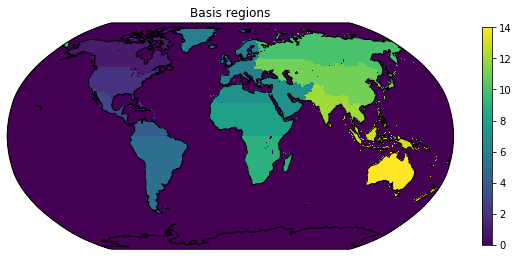

In [67]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(np.array([*f['lon']]), np.array([*f['lat']]), np.array([*f['ancill/basis_regions']]), transform=ccrs.PlateCarree());
ax.coastlines()
ax.set_title('Basis regions')
fig.colorbar(p0, shrink=0.4);

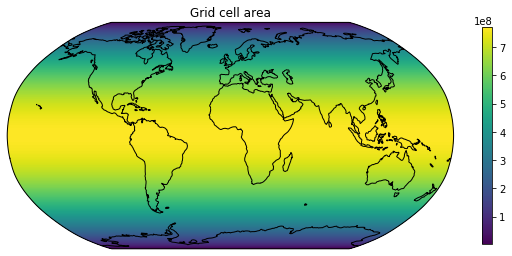

In [66]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(np.array([*f['lon']]), np.array([*f['lat']]), np.array([*f['ancill/grid_cell_area']]), transform=ccrs.PlateCarree());
ax.coastlines()
ax.set_title('Grid cell area')
fig.colorbar(p0, shrink=0.4);

In [69]:
# From README: 'The biosphere fluxes contain monthly net primary production (NPP), heterotrophic respiration (Rh) and fire emissions (BB). 
# All are in g C m-2 month-1'
[*f['biosphere/01']] 

['BB', 'NPP', 'Rh']

In [71]:
# From README: 'burned_fraction is the fraction of each grid cell that burned in that month according to the GFED4s burned area data, 
# burned_area_source indicates what data was used to construct the burned area maps excluding small fires'.
[*f['burned_area/01']]

['burned_fraction', 'source']

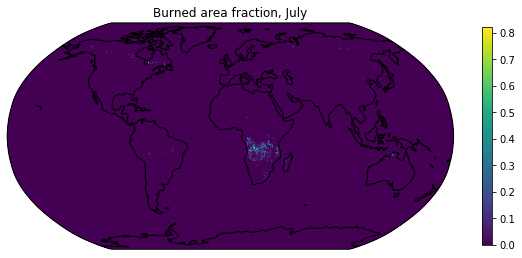

In [72]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(np.array([*f['lon']]), np.array([*f['lat']]), np.array([*f['burned_area/07/burned_fraction']]), transform=ccrs.PlateCarree());
ax.coastlines()
ax.set_title('Burned area fraction, July')
fig.colorbar(p0, shrink=0.4);

From README:

'The emissions group contains, for 12 months (01,02,..,12), 5 datasets: emissions (carbon with units of g C m-2 month-1 and DM with units of kg DM m-2 month-1), small_fire_fraction (unitless), daily fraction (unitless), diurnal cycle (unitless), as well as a group partitioning which contains, for both C and DM, the datasets (all unitless):
- SAVA (Savanna, grassland and shrubland fires)
- BORF (Boreal forest fires)
- TEMF (Temperature forest fires)
- DEFO (Tropical forest fires [deforestation and degradation])
- PEAT (Peat fires)
- AGRI (Agricultural waste burning)'

In [21]:
[*f['emissions/01']], [*f['emissions/01/partitioning']] # need DM and DM_<> partitioning but for all months

(['C',
  'DM',
  'daily_fraction',
  'diurnal_cycle',
  'partitioning',
  'small_fire_fraction'],
 ['C_AGRI',
  'C_BORF',
  'C_DEFO',
  'C_PEAT',
  'C_SAVA',
  'C_TEMF',
  'DM_AGRI',
  'DM_BORF',
  'DM_DEFO',
  'DM_PEAT',
  'DM_SAVA',
  'DM_TEMF'])

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


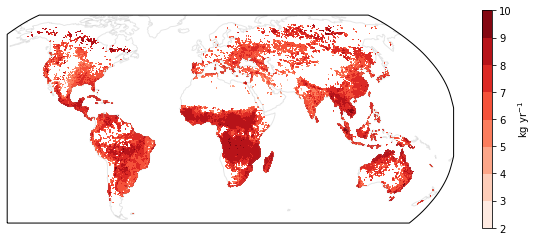

In [123]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.contourf(np.array([*f['lon']]), np.array([*f['lat']]), np.log10(np.sum(dm, 0)*grid_area), transform=ccrs.PlateCarree(), cmap='Reds');
ax.coastlines(color='grey', alpha=0.2)
# ax.set_title('$MeONO_2$ biomass burning emissions')
fig.colorbar(p0, shrink=0.4, label='kg $yr^{-1}$');

From https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

```python
# calculate CO emissions as the product of DM emissions (kg DM per 
# m2 per month), the fraction the specific source contributes to 
# this (unitless), and the emission factor (g CO per kg DM burned)
CO_emissions += DM_emissions * contribution * EF_CO[source]
```

In [80]:
# Extract data on total dry matter emissions and source partitioning
_dm = []
_dm_part_agri = []
_dm_part_borf = []
_dm_part_defo = []
_dm_part_peat = []
_dm_part_sava = []
_dm_part_temf = []
for i in [*f['emissions']]:
    _dm.append([*f[f'emissions/{i}/DM']])
    _dm_part_agri.append([*f[f'emissions/{i}/partitioning/DM_AGRI']])
    _dm_part_borf.append([*f[f'emissions/{i}/partitioning/DM_BORF']])
    _dm_part_defo.append([*f[f'emissions/{i}/partitioning/DM_DEFO']])
    _dm_part_peat.append([*f[f'emissions/{i}/partitioning/DM_PEAT']])
    _dm_part_sava.append([*f[f'emissions/{i}/partitioning/DM_SAVA']])
    _dm_part_temf.append([*f[f'emissions/{i}/partitioning/DM_TEMF']])
dm = np.array(_dm)
dm_part_agri = np.array(_dm_part_agri)
dm_part_borf = np.array(_dm_part_borf)
dm_part_defo = np.array(_dm_part_defo)
dm_part_peat = np.array(_dm_part_peat)
dm_part_sava = np.array(_dm_part_sava)
dm_part_temf = np.array(_dm_part_temf)
# Calculate dry matter emissions from individual sources. Units: kg m-2 month-1
dm_agri = dm*dm_part_agri # del
dm_borf = dm*dm_part_borf
dm_defo = dm*dm_part_defo # del
dm_peat = dm*dm_part_peat # del
dm_sava = dm*dm_part_sava
dm_temf = dm*dm_part_temf

From Akagi et al. (2011):

Emission factors (g kg-1) for species emitted from different types of biomass burning.

Boreal and extratropical forest values are the same for C1-C3 alkyl nitrates. No values for crop residue, pasture maintenance and temperate forest.
- trof - tropical forest
- sava - savanna
- borf - boreal forest

In [23]:
meono2_ef_trof, meono2_ef_sava, meono2_ef_borf = 8.29*1e-3, 5.1*1e-4, 2.83*1e-3 # 8.29×10−3 (1.60×10−2), 5.1×10−4 (3.7×10−4), 2.83×10−3
etono2_ef_trof, etono2_ef_borf = 5.70*1e-3, 1.78*1e-3 # 5.70×10−3, 1.78×10−3
nprono2_ef_trof, nprono2_borf = 0.0003, 3.23*1e-4 # 0.0003, 3.23×10−4
iprono2_ef_trof,a iprono2_ef_borf = 0.001, 3.23*1e-3 # 0.001, 3.23×10−3

In [24]:
# Calculate biomass burning emissions of alkyl nitrates in g m-2 month-1
dm_borf_meono2 = dm_borf*meono2_ef_borf # add temporate forest biomass too using boreal forest emission factor?
dm_sava_meono2 = dm_sava*meono2_ef_sava

dm_borf_etono2 = dm_borf*etono2_ef_borf
dm_sava_etono2 = dm_sava*etono2_ef_trof

dm_borf_nprono2 = dm_borf*nprono2_borf
dm_sava_nprono2 = dm_sava*nprono2_ef_trof

dm_borf_iprono2 = dm_borf*iprono2_ef_borf
dm_sava_iprono2 = dm_sava*iprono2_ef_trof

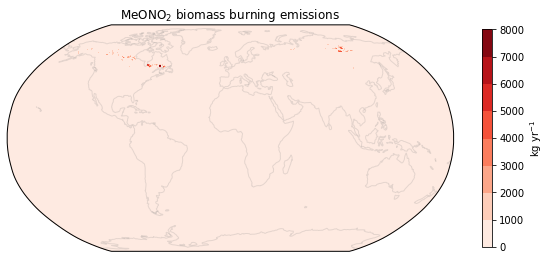

In [117]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.contourf(np.array([*f['lon']]), np.array([*f['lat']]), np.sum(dm_borf_meono2+dm_sava_meono2, 0)*grid_area*1e-3, 
                   transform=ccrs.PlateCarree(), cmap='Reds');
ax.coastlines(color='grey', alpha=0.2)
ax.set_title('$MeONO_2$ biomass burning emissions')
fig.colorbar(p0, shrink=0.4, label='kg $yr^{-1}$');

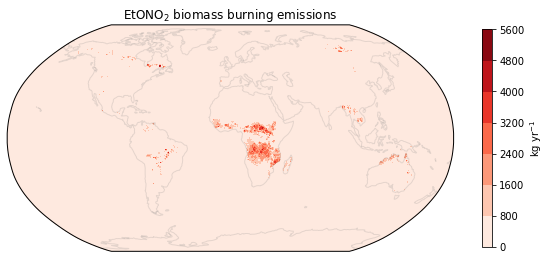

In [119]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.contourf(f['lon'][:], f['lat'][:], np.sum(dm_borf_etono2+dm_sava_etono2, 0)*grid_area*1e-3, 
                   transform=ccrs.PlateCarree(), cmap='Reds');
ax.coastlines(color='grey', alpha=0.2)
ax.set_title('$EtONO_2$ biomass burning emissions')
fig.colorbar(p0, shrink=0.4, label='kg $yr^{-1}$');

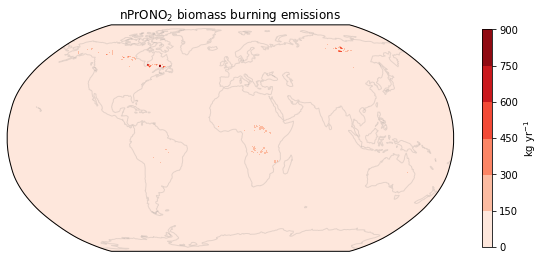

In [120]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.contourf(f['lon'][:], f['lat'][:], np.sum(dm_borf_nprono2+dm_sava_nprono2, 0)*grid_area*1e-3, 
                   transform=ccrs.PlateCarree(), cmap='Reds');
ax.coastlines(color='grey', alpha=0.2)
ax.set_title('$nPrONO_2$ biomass burning emissions')
fig.colorbar(p0, shrink=0.4, label='kg $yr^{-1}$');

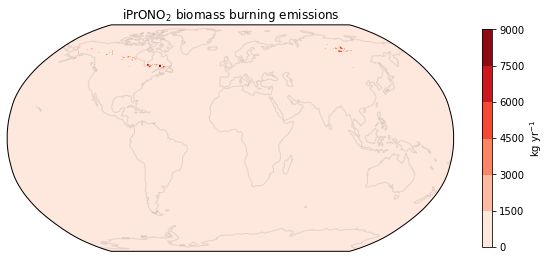

In [121]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.contourf(f['lon'][:], f['lat'][:], np.sum(dm_borf_iprono2+dm_sava_iprono2, 0)*grid_area*1e-3, 
                   transform=ccrs.PlateCarree(), cmap='Reds');
ax.coastlines(color='grey', alpha=0.2)
ax.set_title('$iPrONO_2$ biomass burning emissions')
fig.colorbar(p0, shrink=0.4, label='kg $yr^{-1}$');

In [73]:
grid_area = f['/ancill/grid_cell_area'][:]

In [92]:
np.sum((dm_borf_meono2+dm_sava_meono2)*grid_area)*1e-9*12 # g to Tg: *1e-12, g to Gg: *1e-9

27.275074560000004

From Simpson et al. (2002):

'...Based on these values, global savanna burning emissions for the five C1–C4 alkyl nitrates reported here are estimated to total roughly 6.6 Gg/yr (mainly as MeONO2) during the flaming stage, and 1.2 Gg/yr (mainly as C2–C4 alkyl nitrates) during the smoldering stage, for a total on the order of 8 Gg/yr (Table 3). For global biomass burning, summedC1–C4 alkyl nitrate emissions on the order of18 Gg/ yr are estimated. In both cases, MeONO2 emissions during the flaming stage comprise a majority (roughly two-thirds) of the total C1–C4 alkyl nitrate emissions. [16] 

The MeONO2 emissions from savanna and global biomass burning are estimated to total roughly 5.4 and 12.6 Gg/yr, respectively (Table 3). By comparison, for an atmos- phere of about 1.7 ? 1020 moles of air, a globally averaged MeONO2 mixing ratio of roughly 2 pptv, and a global MeONO2 lifetime of 0.1 yr, the global MeONO2 source is calculated to be on the order of 300 Gg/yr. That is, MeONO2 released from global biomass burning likely accounts for only a small portion (about 4%) of the global MeONO2 source.'

In [124]:
f.close()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(ds.longitude.values, ds.latitude.values, ds[7,...]*60*60*24*30*12*510064472*1e6/1e9, transform=ccrs.PlateCarree(), cmap='viridis_r');
fig.colorbar(p0, shrink=0.2);